# COVID-19 Data Analysis
**Joe Corliss**

Data download links

* Confirmed cases: [time_series_covid19_confirmed_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
* Deaths: [time_series_covid19_deaths_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)
* Recovered: [time_series_covid19_recovered_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)

## Execution Options

In [1]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': 100, 'deaths': 10}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 10  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [2]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [3]:
import sys

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [5]:
# Check package versions
assert sys.version.split()[0] == '3.6.10', 'Unexpected Python version: expected 3.6.10, got {}'.format(sys.version.split()[0])
assert mpl.__version__ == '3.1.3', 'Unexpected matplotlib version: expected 3.1.3, got {}'.format(mpl.__version__)
assert np.__version__ == '1.18.1', 'Unexpected numpy version: expected 1.18.1, got {}'.format(np.__version__)
assert pd.__version__ == '1.0.3', 'Unexpected pandas version: expected 1.0.3, got {}'.format(pd.__version__)
assert sklearn.__version__ == '0.22.1', 'Unexpected scikit-learn version: expected 0.22.1, got {}'.format(sklearn.__version__)

In [6]:
from sklearn import linear_model

In [7]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Functions

In [8]:
def compare_locales(df1, df2):
    """Check whether two time series DataFrames have the same State/Country indices."""
    if df1.shape != df2.shape:
        return False
    else:
        comparison = (df1.iloc[:, :2] == df2.iloc[:, :2]) | (df1.iloc[:, :2].isna() & df2.iloc[:, :2].isna())
        return comparison.all().all()

## Load data

In [9]:
confirmed = pd.read_csv(DATA_PATH + 'time_series_covid19_confirmed_global.txt')
deaths = pd.read_csv(DATA_PATH + 'time_series_covid19_deaths_global.txt')
# recovered = pd.read_csv(DATA_PATH + 'time_series_covid19_recovered_global.txt')

In [10]:
print('Confirmed data updated to:', confirmed.columns[-1])
print('Deaths data updated to:', deaths.columns[-1])

Confirmed data updated to: 3/29/20
Deaths data updated to: 3/29/20


In [11]:
assert compare_locales(confirmed, deaths), 'confirmed and deaths DataFrames have different locales'

In [12]:
values = eval(metric)

In [13]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  253 non-null    object 
 2   Lat             253 non-null    float64
 3   Long            253 non-null    float64
 4   1/22/20         253 non-null    int64  
 5   1/23/20         253 non-null    int64  
 6   1/24/20         253 non-null    int64  
 7   1/25/20         253 non-null    int64  
 8   1/26/20         253 non-null    int64  
 9   1/27/20         253 non-null    int64  
 10  1/28/20         253 non-null    int64  
 11  1/29/20         253 non-null    int64  
 12  1/30/20         253 non-null    int64  
 13  1/31/20         253 non-null    int64  
 14  2/1/20          253 non-null    int64  
 15  2/2/20          253 non-null    int64  
 16  2/3/20          253 non-null    int64  
 17  2/4/20          253 non-null    int

Check for missing values:

In [14]:
assert (~values.isnull().any()[1:]).all(), 'Unexpected missing data!'

In [15]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [16]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [17]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
164,NaN,Namibia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,4,7,7,8,8,8,11
239,NaN,Laos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,6,6,8,8
90,NaN,Cyprus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,6,6,14,26,26,33,46,49,67,67,84,95,116,124,132,146,162,179,214
41,Nova Scotia,Canada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,12,14,15,21,28,41,51,68,73,90,110,122
49,Anhui,China,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990


## Look at Countries Split Up by Province/State

Which countries have their time series broken up into different provinces/states?

In [18]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
France            10
United Kingdom    10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [19]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,3/29/20
9,Australia,New South Wales,1791
14,Australia,Victoria,769
11,Australia,Queensland,656
15,Australia,Western Australia,311
12,Australia,South Australia,299
8,Australia,Australian Capital Territory,77
13,Australia,Tasmania,66
10,Australia,Northern Territory,15
44,Canada,Quebec,2840
42,Canada,Ontario,1355


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [20]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [21]:
values.drop(columns={'province', 'country'}, inplace=True)

Plot values for each locale (repeat the second cell below) - Skip locales with fewer than 1,000 cases today:

In [22]:
idx = 0

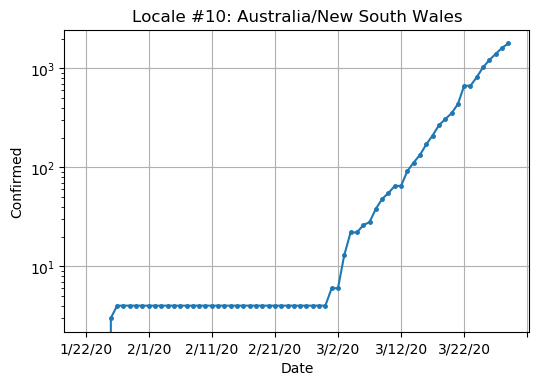

In [23]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.grid(True)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    idx += 1

Stack the data:

In [24]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [25]:
values_melt.sample(5)

,locale,date,value
3866,China/Qinghai,2/6/20,18
16354,Montenegro,3/26/20,69
1367,Estonia,1/27/20,0
15399,United Kingdom/Channel Islands,3/22/20,32
1040,Brazil,1/26/20,0


In [26]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

Filter by the minimum required metric value:

In [27]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [28]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [29]:
values_melt.sample(5)

,locale,date,value
6374,China/Anhui,2020-02-16,2.983175
11586,Spain,2020-03-07,2.698970
5881,China/Hubei,2020-02-14,4.735647
17127,Oman,2020-03-29,2.222716
14391,United Kingdom,2020-03-18,3.419295


## Construct Final Datasets

In [30]:
X_schema = pd.DataFrame(columns=['locale', 'date']
                                + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)])

In [31]:
y_schema = pd.DataFrame(columns=['locale', 'date']
                                + ['value_d+{}'.format(days_horizon)])

In [32]:
X_train = X_schema.copy()
y_train = y_schema.copy()

In [33]:
X_pred = X_schema.copy()

In [34]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    idx = 0
    while idx + (days_history - 1) + days_horizon <= values_melt_locale.shape[0] - 1:
        locale_date_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        
        X_train_to_append = dict(zip(X_train.columns[2:], values_melt_locale['value'].iloc[idx : idx + days_history]))
        X_train_to_append.update(locale_date_to_append)
        X_train = X_train.append(X_train_to_append, ignore_index=True)
        
        y_train_to_append = {y_train.columns[-1]: values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]}
        y_train_to_append.update(locale_date_to_append)
        y_train = y_train.append(y_train_to_append, ignore_index=True)
        
        idx += 1
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        locale_date_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        X_pred_to_append = dict(zip(X_pred.columns[2:], values_melt_locale['value'].iloc[-days_history:]))
        X_pred_to_append.update(locale_date_to_append)
        X_pred = X_pred.append(X_pred_to_append, ignore_index=True)

In [35]:
X_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
y_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
X_pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

Check the size of the dataset:

In [36]:
print('The training data has {} samples'.format(X_train.shape[0]))
print('Predictions will be made for {} locales'.format(X_pred.shape[0]))

The training data has 1310 samples
Predictions will be made for 96 locales


In [37]:
X_train.head()

value_d-9  value_d-8  value_d-7  value_d-6  value_d-5  \
locale  date                                                                
Austria 2020-03-17   2.017033   2.117271   2.260071   2.390935   2.480007   
        2020-03-18   2.117271   2.260071   2.390935   2.480007   2.702431   
        2020-03-19   2.260071   2.390935   2.480007   2.702431   2.816241   
        2020-03-20   2.390935   2.480007   2.702431   2.816241   2.934498   
        2020-03-21   2.480007   2.702431   2.816241   2.934498   3.007748   

                    value_d-4  value_d-3  value_d-2  value_d-1  value_d0  
locale  date                                                              
Austria 2020-03-17   2.702431   2.816241   2.934498   3.007748  3.124504  
        2020-03-18   2.816241   2.934498   3.007748   3.124504  3.216430  
        2020-03-19   2.934498   3.007748   3.124504   3.216430  3.303844  
        2020-03-20   3.007748   3.124504   3.216430   3.303844  3.378034  
        2020-03-21   3.124504   3.216430   3.303844   3.378034  3.449324

In [38]:
y_train.head()

value_d+7
locale  date                 
Austria 2020-03-17   3.722881
        2020-03-18   3.747256
        2020-03-19   3.839415
        2020-03-20   3.884059
        2020-03-21   3.917558

In [39]:
X_pred.head()

,,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0
locale,date,,,,,,,,,,
Argentina,2020-03-29,2.107210,2.198657,2.424882,2.478566,2.587711,2.587711,2.700704,2.770115,2.838849,2.872156
Armenia,2020-03-29,2.133539,2.204120,2.287802,2.371068,2.396199,2.423246,2.462398,2.517196,2.609594,2.627366
Australia/New South Wales,2020-03-29,2.547775,2.639486,2.825426,2.825426,2.912753,3.012415,3.086004,3.147676,3.208710,3.253096
Australia/Queensland,2020-03-29,2.264818,2.344392,2.413300,2.503791,2.598791,2.646404,2.692847,2.744293,2.795880,2.816904
Australia/Victoria,2020-03-29,2.082785,2.359835,2.550228,2.550228,2.613842,2.668386,2.716003,2.758912,2.835691,2.885926


## Maching Learning

In [40]:
model = linear_model.LassoCV(
    eps=1e-8,
    fit_intercept=True,
    max_iter=100000,
    tol=1e-6,
    verbose=False,
    n_jobs=-1,
    random_state=random_state,
)

In [41]:
model.fit(X_train.values, y_train.iloc[:, -1])

LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=1e-06, verbose=False)

In [42]:
model.coef_

array([ 0.1779198 , -0.00761548, -0.25939675, -0.        , -0.22631412,
       -0.29717294, -0.66880623, -0.39185531,  0.26128617,  2.40828692])

In [43]:
model.intercept_

0.0105351513993317

In [44]:
model.alpha_

7.317762336055515e-06

In [45]:
min(model.alphas_), max(model.alphas_)

(4.286028634386818e-09, 0.42860286343868126)

In [46]:
model.n_iter_

13282

In [47]:
model.score(X_train.values, y_train.iloc[:, -1])

0.9915141271752059

## Predictions

In [48]:
X_pred['value_d+{}'.format(days_horizon)] = model.predict(X_pred)

In [49]:
if log_metric:
    for col in X_pred.columns:
        X_pred[col] = X_pred[col].map(lambda x: round(10**x))

In [50]:
X_pred

,,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,
Argentina,2020-03-29,128,158,266,301,387,387,502,589,690,745,1419
Armenia,2020-03-29,136,160,194,235,249,265,290,329,407,424,783
Australia/New South Wales,2020-03-29,353,436,669,669,818,1029,1219,1405,1617,1791,3403
Australia/Queensland,2020-03-29,184,221,259,319,397,443,493,555,625,656,1079
Australia/Victoria,2020-03-29,121,229,355,355,411,466,520,574,685,769,1290
Austria,2020-03-29,2388,2814,3582,4474,5283,5588,6909,7657,8271,8788,13773
Bahrain,2020-03-29,285,305,334,377,392,419,458,466,476,499,602
Belgium,2020-03-29,2257,2815,3401,3743,4269,4937,6235,7284,9134,10836,27934
Brazil,2020-03-29,793,1021,1546,1924,2247,2554,2985,3417,3904,4256,7490
